### Bioneuron Oracle Notebook
#### Peter Duggins
#### April 2017
#### https://github.com/psipeter/bioneuron_oracle

This notebook includes methods for specifying weights into an emsemble of biologically realistic neurons such that it performs representation and dynamics according to the NEF. These 'bioneurons' are implemented in NEURON based off of a reduced model of a pyramidal neuron by Bahl et al (2012). It begins by defining a bioneuron class that includes the NEURON objects needed to track voltage, spikes, etc, as well as the required nengo methods to run in simulation. It then redefines some classes in the nengo builder to allow construction of bioensembles and transmission of spikes to the bioneurons' synapses. During the build, synapses are created at specified locations on the bioneurons' dendrites, and are assigned a synaptic weight that has been decomposed into encoders and decoders. Whereas previous bioneuron methods trained the enoders, this notebook seeks to distribute encoders randomly in a manner that ensures heterogeneity of bioneuron response curves, then trains decoders using NEF methods such as the least-squares solver or Aaron Voelker's Oracle. It then provides tests for the efficacy of these procedures by finding the error in the bioensemble's decoded output for various choices of encoder, decoder, and dynamical system.

### Install NEURON and other dependencies
change --prefix to another directory. If you're using virtualenv and virtualenvwrapper, this will be your your /HOME/USER/.local/directory

```bash
pip install nengo matplotlib seaborn numpy pandas

wget http://www.neuron.yale.edu/ftp/neuron/versions/v7.4/nrn-7.4.tar.gz
tar xzf nrn-7.4.tar.gz
cd nrn-7.4
./configure --prefix=/home/$USER/.local --without-iv --with-nrnpython
make
(sudo) make install
cd src/nrnpython
python setup.py install
cd ../../..
```

### Install channel mechanisms for the bahl.hoc NEURON model
To run the NEURON model, bahl.hoc, you must download the .hoc file and .mod files for every ion channel present in the model. These come with the repo, but must be compiled with the NEURON you've just installed locally.

Be sure to change the path to your .local directory to compile the NEURON channel mechanisms.

```bash
git clone https://github.com/psipeter/bioneuron_oracle.git
cd bioneuron_oracle/NEURON_models/channels/
/home/$USER/.local/x86_64/bin/nrnivmodl
```

The first line of `../bahl.hoc` points NEURON towards the location of these compiled channel files:
```
nrn_load_dll("./channels/x86_64/.libs/libnrnmech.so")
```

If this doesn't work, try giving the full path:
```
nrn_load_dll("PATH_TO_REPO/bioneuron_oracle/NEURON_models/channels/x86_64/.libs/libnrnmech.so")
```

If the python kernel crashes at some point and you get an error in the terminal that says "NEURON: syntax error [...] insert ih", it means that the channels weren't initialized properly.

# Bioneuron Methods
### Define bioneuron class

In [1]:
%matplotlib inline
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import neuron
from nengo.utils.matplotlib import rasterplot

# EDIT this to point to your local repository
# neuron.h.load_file('/home/arvoelke/CTN/bioneuron_oracle/NEURON_models/bahl.hoc')
neuron.h.load_file('/home/pduggins/bioneuron_oracle/NEURON_models/bahl.hoc')

class BahlNeuron(nengo.neurons.NeuronType):
    '''compartmental neuron from Bahl et al 2012'''

    probeable=('spikes','voltage')
    def __init__(self,encoders,gains,w_bias_from):
        super(BahlNeuron,self).__init__()
        self.encoders=encoders
        self.gains=gains
        self.w_bias_from=w_bias_from #label of conn.pre to emulate biases off
        #stores the input decoders, calculated connection weights, weight_bias (only used for the conn with w_bias=True, 
        #and synaptic locations for each connection into bionrn
        self.inputs={} 
        super(BahlNeuron, self).__init__()

    def create(self,bio_idx):
        return self.Bahl(bio_idx,self.encoders[bio_idx],self.gains[bio_idx],self.w_bias_from)

    class Bahl(object):
        def __init__(self,bio_idx,encoder,gain,w_bias_from):
            self.bio_idx=bio_idx
            self.encoder=encoder             #single encoder for the bioneuron e_j.
            self.gain=gain                   #single gain for the bioneuron alpha_j
            self.w_bias_from=w_bias_from
            self.synapses = {}
            self.netcons = {}
            self.cell = neuron.h.Bahl()
        def start_recording(self):
            '''NEURON recording attributes'''
            self.v_record = neuron.h.Vector()
            self.v_record.record(self.cell.soma(0.5)._ref_v)
            self.ap_counter = neuron.h.APCount(self.cell.soma(0.5))
            self.t_record = neuron.h.Vector()
            self.t_record.record(neuron.h._ref_t)
            self.spikes = neuron.h.Vector()
            self.ap_counter.record(neuron.h.ref(self.spikes))
            self.spikes_last=[]
            
    def rates(self, x, gain, bias): #todo: remove this without errors
        return x

    def gain_bias(self, max_rates, intercepts): #todo: remove this without errors
        return np.ones(len(max_rates)),np.ones(len(max_rates))

    def step_math(self,dt,spiked,neurons,voltage,time):
        '''run NEURON forward one nengo timestep. Compare the current and previous spike arrays
        for this bioneuron. If they're different, the neuron has spiked, so communicate this to nengo'''
        t_neuron=time*1000
        neuron.run(t_neuron) 
        new_spiked=[]
        new_voltage=[]
        for nrn in neurons:
            spike_times=np.array(nrn.spikes)
            spike_times_last=np.array(nrn.spikes_last)
            count=len(spike_times)-len(spike_times_last)
            new_spiked.append(count)
            volt=np.array(nrn.v_record)[-1] #fails if neuron.init() not called at right times
            new_voltage.append(volt)
            nrn.spikes_last=spike_times
        spiked[:]=np.array(new_spiked)/dt
        voltage[:]=np.array(new_voltage)

In [2]:
class ExpSyn(object):
    '''Conductance-based synapses. There are two types, excitatory and inhibitory, with different
    reversal potentials. If the synaptic weight is above zero, initialize an excitatory synapse, 
    else initialize an inhibitory syanpse with the abolute value of the synaptic weight.'''
    def __init__(self, sec, weight, tau, e_exc=0.0, e_inh=-80.0):
        self.type = 'ExpSyn'
        self.tau = tau
        self.e_exc = e_exc
        self.e_inh = e_inh
        self.syn = neuron.h.ExpSyn(sec)
        self.syn.tau=2*1000*self.tau #arbitrary 2x multiply to offset phase shift in bio decode
        self.weight = weight
        if self.weight >= 0.0: self.syn.e = self.e_exc
        else: self.syn.e = self.e_inh
        self.spike_in = neuron.h.NetCon(None, self.syn) #time of spike arrival assigned in nengo step
        self.spike_in.weight[0]=abs(self.weight)

### Nengo Operators and Builders

In [3]:
from nengo.builder import Builder, Operator, Signal
from nengo.dists import get_samples
from nengo.builder.connection import build_decoders
from nengo.builder.connection import BuiltConnection

class SimBahlNeuron(Operator):
    def __init__(self, neurons, n_neurons, output, voltage, states):
        super(SimBahlNeuron, self).__init__()
        self.neurons = neurons
        self.neurons.father_op = self
        self.reads = [states[0]]
        self.sets = [output, voltage]
        self.updates = []
        self.incs = []
        self.label = None
        self.neurons.neurons = [self.neurons.create(i) for i in range(n_neurons)]
        self.inputs = self.neurons.inputs
        super(SimBahlNeuron, self).__init__()

    def make_step(self, signals, dt, rng):
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neurons.step_math(dt,output,self.neurons.neurons,voltage,time)
        return step_nrn
    
    @property
    def time(self):
        return self.reads[0]
    
    @property
    def output(self):
        return self.sets[0]

    @property
    def voltage(self):
        return self.sets[1]

    def init_connection(self,inpt):
        '''Given a parcicular connection (labeled by inpt=conn.pre),grab the optimal decoders
        calculated for that connection and the number of presynapic neurons in conn.pre.
        At each location in the specified syn_locations list, create a synapse with weight equal to
        w_ij=np.dot(d_i,alpha_j*e_j)+w_bias, where d_i is the optimal presynaptic decoder, e_j is the single
        bioneuron encoder specified in the encoders list, and w_bias is a weight perturbation that emulates
        the bias in a LIF neuron. Once synapses are created and added to the bioneuron attribute .synapses, 
        initialize the NEURON recording variables and call neuron.init()'''
        for bionrn in range(len(self.neurons.neurons)):
            bioneuron=self.neurons.neurons[bionrn]
            input_decoders=self.inputs[inpt]['input_decoders']
            syn_locations=self.inputs[inpt]['syn_locations'][bionrn]
            if bioneuron.w_bias_from == inpt:  
                weights_bias=self.inputs[inpt]['weights_bias'][bionrn]
            pre_neurons=input_decoders.shape[0]
            bioneuron.synapses[inpt]=np.empty((pre_neurons,n_syn),dtype=object)
            for pre in range(pre_neurons):
                for syn in range(n_syn):
                    decoder=input_decoders[pre]
                    encoder=bioneuron.encoder
                    gain=bioneuron.gain
                    location=syn_locations[pre][syn]
                    section=bioneuron.cell.apical(location)
                    weight=np.dot(decoder,gain*encoder)
                    if bioneuron.w_bias_from == inpt:
                        weight+=weights_bias[pre]
                    self.inputs[inpt]['weights'][bionrn,pre,syn]=weight #update weight matrix for this input (debugging)
                    synapse=ExpSyn(section,weight,tau) #create a synapse with the computed weight at this location
                    bioneuron.synapses[inpt][pre][syn]=synapse            
            bioneuron.start_recording() #todo - call elsewhere so it's not redundant
        neuron.init()


In [4]:
class TransmitSpikes(Operator):
    '''Operator to deliver (unweighted) spikes from the presynaptic population into a bioensemble'''
    def __init__(self, ens_pre_label, spikes, bahl_op, states):
        self.ens_pre_label = ens_pre_label
        self.bahl_op = bahl_op
        self.neurons = bahl_op.neurons.neurons
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        super(TransmitSpikes, self).__init__()
        
    @property
    def spikes(self):
        return self.reads[0]
        
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            'event-based method'
            tback=time-dt
            t_neuron=tback*1000
            for n in range(spikes.shape[0]): #for each input neuron
                my_spikes=spikes[n] #actual spikes
                if my_spikes > 0: #if input neuron spiked
                    for nrn in self.neurons: #for each bioneuron
                        for syn in nrn.synapses[self.ens_pre_label][n]: #for each synapse conn. to input
                            syn.spike_in.event(t_neuron) #add a spike at time (ms)
        return step

In [19]:
@Builder.register(BahlNeuron)
def build_bahlneuron(model,neuron_type,ens):
    model.sig[ens]['voltage'] = Signal(np.zeros(ens.ensemble.n_neurons),
                        name='%s.voltage' %ens.ensemble.label)
    op=SimBahlNeuron(neurons=neuron_type,
                     n_neurons=ens.ensemble.n_neurons,
                     output=model.sig[ens]['out'],
                     voltage=model.sig[ens]['voltage'],
                     states=[model.time])
    model.add_op(op)

@Builder.register(nengo.Ensemble)
def build_ensemble(model,ens):
    nengo.builder.ensemble.build_ensemble(model,ens)

@Builder.register(nengo.Connection)
def build_connection(model,conn):
    '''Method to build connections into bioensembles.
    Calculates the optimal decoders for this conneciton as though the presynaptic neuron 
    was connecting to a hypothetical point neuron. These decoders are used to calculate
    the synaptic weights in init_connection().
    Adds a transmit_spike operator for this connection to the model
    '''
    use_nrn = (
        isinstance(conn.post, nengo.Ensemble) and
        isinstance(conn.post.neuron_type, BahlNeuron))
    if use_nrn: #bioneuron connection
        rng = np.random.RandomState(model.seeds[conn]) 
        model.sig[conn]['in']=model.sig[conn.pre]['out']
        transform = get_samples(conn.transform, conn.size_out, d=conn.size_mid, rng=rng)
        eval_points, weights, solver_info = build_decoders(model, conn, rng, transform)
        op=conn.post.neuron_type.father_op
        op.label=conn.post.label
        op.inputs[conn.pre.label]={}
        syn_locations=get_syn_locations(rng,conn) #defined below, for modularity during testing
        if op.neurons.neurons[0].w_bias_from == conn.pre.label: #emulate bias from this connection?
            weights_bias=get_weights_bias(conn) #emulated biases in weight space; defined below, for modularity
            op.inputs[conn.pre.label]['weights_bias']=weights_bias     
        op.inputs[conn.pre.label]['syn_locations']=syn_locations
        op.inputs[conn.pre.label]['input_decoders']=weights.T #may break for bio-bio connections
        op.inputs[conn.pre.label]['weights']=np.zeros((conn.post.n_neurons,conn.pre.n_neurons,n_syn)) #todo: n_syn
        op.init_connection(conn.pre.label)
        model.add_op(
            TransmitSpikes(conn.pre_obj.label,model.sig[conn.pre]['out'],op,states=[model.time]))
        model.params[conn] = BuiltConnection(eval_points=eval_points,
                                             solver_info=solver_info,
                                             transform=transform,
                                             weights=weights)

    else: #normal connection
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/builder/builder.py:232: UserWarning: Type '<class '__main__.BahlNeuron'>' already has a builder. Overwriting.
  % nengo_class)


### Helper Functions

In [6]:
from nengo.builder.ensemble import get_activities
def decode_bias(bias, activity):
    '''
    From Andreas Stockel 
    Emulate biases by decoding them separately off the LIF population and adding it to the resulting connection weights
    https://github.com/ctn-waterloo/nengo_conductance_synapses/blob/master/ifcondexp.ipynb
    '''
    
    A = activity # Fetch theactivity matrix
    m, n = A.shape  # samples, neurons
    Y = np.tile(bias, (m, 1))  # Desired output function Y -- just repeat "bias" m times
    I = np.eye(n) * ((np.max(A) * 0.1)**2) # Regularisation matrix
    # Calculate the decoders using a least squares estimate
    return (np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)/m + I),A.T),Y).T) / m

In [7]:
def gen_enc_gain_bias(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,
                pre_seed, bio_seed,input_type='prime_sinusoids',n_eval_points=10):
    
    '''
    Build a pre-simulation network to draw encoders, gains, and biases from Nengo,
    scale them, and return a weight matrix that emulates the bias
    (by adding weights to the synaptic weights in init_connection()
    '''
    
    with nengo.Network(label='preliminary') as pre_model:
        if input_type == 'prime_sinusoids':
            stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        elif input_type == 'step_input':
            stim = nengo.Node(lambda t: step_input(t,dim,t_final,dt,n_eval_points))
        pre=nengo.Ensemble(n_neurons=pre_neurons,dimensions=dim,label='pre',seed=pre_seed)
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif',seed=bio_seed)
        post=nengo.Ensemble(n_neurons=pre_neurons,dimensions=dim,seed=9,label='post')
        conn_stim_to_pre=nengo.Connection(stim,pre,synapse=None)
        conn_pre_to_lif=nengo.Connection(pre,lif,synapse=tau)
        conn_lif_to_post=nengo.Connection(lif,post,synapse=tau)
    with nengo.Simulator(pre_model,dt=dt) as pre_sim:
        pre_activities = get_activities(pre_sim.data[pre], pre, pre_sim.data[pre].eval_points)
        encoders=pre_sim.data[lif].encoders
        pre_decoders=pre_sim.data[conn_pre_to_lif].weights.T
        biases=pre_sim.data[lif].bias
        gains=pre_sim.data[lif].gain
        lif_decoders=pre_sim.data[conn_lif_to_post].weights.T
    weights_bias = decode_bias(biases,pre_activities)
    return encoders, gains, weights_bias

def delete_bioneurons(bioensemble):
    '''NEURON garbage collection, so that successive model initializations don't accumulate NEURON objects'''
    for bioneuron in bioensemble.neuron_type.father_op.neurons.neurons:
        del bioneuron

In [8]:
def get_syn_locations(rng,conn):
    '''same locations per connection and per bioneuron'''
    rng2=np.random.RandomState(seed=333)
    syn_locations=np.array([rng2.uniform(0,1,size=(conn.pre.n_neurons,n_syn)) for n in range(conn.post.n_neurons)])
    return syn_locations

In [9]:
def get_weights_bias(conn):
    print 'Emulating bias from %s to %s'%(conn.pre.label,conn.post.label)
    e, g, weights_bias = gen_enc_gain_bias(
            conn.pre.n_neurons,conn.post.n_neurons,conn.synapse,conn.post.dimensions,
            n_syn,0.001,1.0,conn.pre.seed,conn.post.seed,'prime_sinusoids')
    return weights_bias

### Stimuli

In [10]:
def prime_sinusoids(t,dim,t_final):
    primes=[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101,
            103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
    our_primes=primes[:dim]
    t_per_dim=t_final/dim
    epoch=int(t/t_per_dim)
    reordered_primes=[our_primes[(p + epoch) % len(our_primes)] for p in range(len(our_primes))]
    frequencies=np.pi*np.array(reordered_primes)
    values = np.array([np.sin(w*t) for w in frequencies])
    return values

In [11]:
prime_sinusoids(np.pi/2,3,2*np.pi)

array([-0.43030122,  0.78553281, -0.44280997])

In [12]:
# with nengo.Network() as eval_model:
#     ens=nengo.Ensemble(1,2,n_eval_points=10)
# with nengo.Simulator(eval_model) as sim:
#     print sim.data[ens].eval_points

In [13]:
def step_input(t,dim,t_final,dt,n_eval_points):

    '''
    Creates an (dim x n_eval_points) array where each row contains a uniform tiling from -1 to 1.
    To sample the dim-dimensional space, take every combination of values in this array.
    To do this, assume that each value is played for t_per_value time, and begin by taking
    eval_points[d,0] for each dimension. Then leave all but 1 dimension the same, and take
    eval_points[dim,1] from that dimension. Repeat until all values of the d_last dimesion are sampled.
    Then take eval_points[d,0] for d=0...dim-1, eval_points[dim-1,1] for the 2nd to last dimension,
    and repeat recursively up the array.
    
    Example, where 0 is the top dimension and 2 is the deepest dimension:
        t_idx=int(t/dt)
        dim_2=int(t_idx/t_per_val)%n_eval_points
        dim_1=int(t_idx/t_per_val/n_eval_points)%n_eval_points
        dim_0=int(t_idx/t_per_val/(n_eval_points**2))%n_eval_points
        return [eval_points[0,dim_0],eval_points[1,dim_1],eval_points[2,dim_2]]
    
    n_eval_points: number of evaluation points to sample for each dimension
    '''
    n_vals=n_eval_points**dim
    n_times=int(t_final/dt)
    assert n_vals < n_times, "must be at least one timestep per constant value"
    t_per_val=int(n_times/n_vals)
    x_vals=np.linspace(-1,1,n_eval_points)
    eval_points=np.zeros((dim,n_eval_points))
    for d in range(dim):
        eval_points[d]=x_vals

    def get_eval_point(t,eval_points):
        t_idx=int(t/dt)
        idxs=np.zeros((dim)).astype(int)
        for d in range(dim):
            idxs[d]=int(t_idx / t_per_val / (n_eval_points ** d)) % n_eval_points
        return [eval_points[d,idxs[d]] for d in range(dim)]

    return np.array(get_eval_point(t,eval_points))

In [14]:
step_input(t=0.123,dim=2,t_final=1.0,dt=0.001,n_eval_points=10)

array([-0.55555556, -0.77777778])

### Simulation and Plotting

In [15]:
def simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
             pre_seed,bio_seed,input_type,n_eval_points=10,
             decoders_bio=None,plots={'spikes','voltage','decode'}):
    '''
    Simulate a feedforward network [stim]-[LIF]-[BIO], and compare to [stim]-[LIF]-[LIF].
    
    encoders: encoders for bioneurons calculated for a hypothetical LIF population in gen_enc_gain_bias()
    w_bias_from: ensemble connecting to a bioensemble from which the bioneurons' biases are emulated
    bio_seed: ensemble seed for bioensemble
    pre_seed: ensemble seed for lif emsemble
    decoders_bio: use the output decoders for [BIO]-[probe] from a previous simulation rather than
                    calculating them again using nengo.solver.LstsqL2()
    '''
    with nengo.Network() as model:
        if input_type == 'prime_sinusoids':
            stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        elif input_type == 'step_input':
            stim = nengo.Node(lambda t: step_input(t,dim,t_final,dt,n_eval_points))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,w_bias_from))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)
        
    '''make sick plotz'''
    sns.set(context='poster')

    if 'spikes' in plots:
        '''spike raster for PRE, BIO and comparison LIF ensembles'''
        figure, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
        rasterplot(sim.trange(),sim.data[probe_pre_spikes],ax=ax1,use_eventplot=True)
        ax1.set(ylabel='pre',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax3,use_eventplot=True)
        ax3.set(xlabel='time (s)',ylabel='lif') #,yticks=([])

    if 'voltage' in plots:
        '''voltage trace for a specific bioneuron'''
        figure2,ax3=plt.subplots(1,1,sharex=True)
        bio_idx=0
        neuron=bio.neuron_type.father_op.neurons.neurons[bio_idx]
        ax3.plot(dt*np.arange(0,len(np.array(neuron.v_record))),np.array(neuron.v_record))
        ax3.set(xlabel='time (ms)', ylabel='Voltage (mV)')

    if 'decode' in plots:
        '''decoded output of bioensemble'''
        figure3,ax4=plt.subplots(1,1,sharex=True)
        lpf = nengo.Lowpass(tau)
        solver = nengo.solvers.LstsqL2(reg=0.01)
        if decoders_bio==None:
            decoders_bio, info = solver(
                                    lpf.filt(sim.data[probe_bio_spikes], dt=dt),
                                    lpf.filt(sim.data[probe_pre], dt=dt)) #one filter on target
                                    # lpf.filt(lpf.filt(sim.data[probe_pre], dt=P['dt_nengo']), dt=P['dt_nengo']))
        A_bio=lpf.filt(sim.data[probe_bio_spikes], dt=dt)
        xhat_bio=np.dot(A_bio,decoders_bio)
        rmse_bio=np.sqrt(np.average((sim.data[probe_direct]-xhat_bio)**2))
        rmse_lif=np.sqrt(np.average((sim.data[probe_direct]-sim.data[probe_lif])**2))
        ax4.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
        ax4.plot(sim.trange(),sim.data[probe_lif],label='lif, rmse=%.5f'%rmse_lif)
        ax4.plot(sim.trange(),sim.data[probe_direct],label='direct')
        ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax4.legend() #prop={'size':8}
    
    delete_bioneurons(bio)
    return decoders_bio

# Testing Gains, Biases, and Decoders

In [16]:
pre_neurons=100
n_neurons=50
tau=0.01
dim=1
n_syn=1
dt=0.001
t_final=1.0
pre_seed=3
bio_seed=6

#generate synaptic locations for each neuron
# rng=np.random.RandomState(seed=333)
# syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])

## No gains, no biases
Simplest setup - single encoder per neuron, one synapse, gains and biases not accounted for, synaptic locations identical for every bioneuron (still a unique location for every synapse on the dendrite)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:32.                                                 


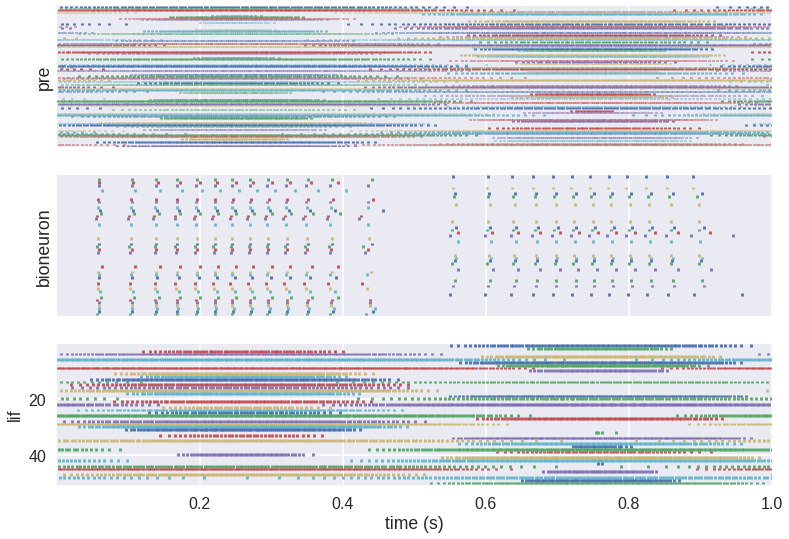

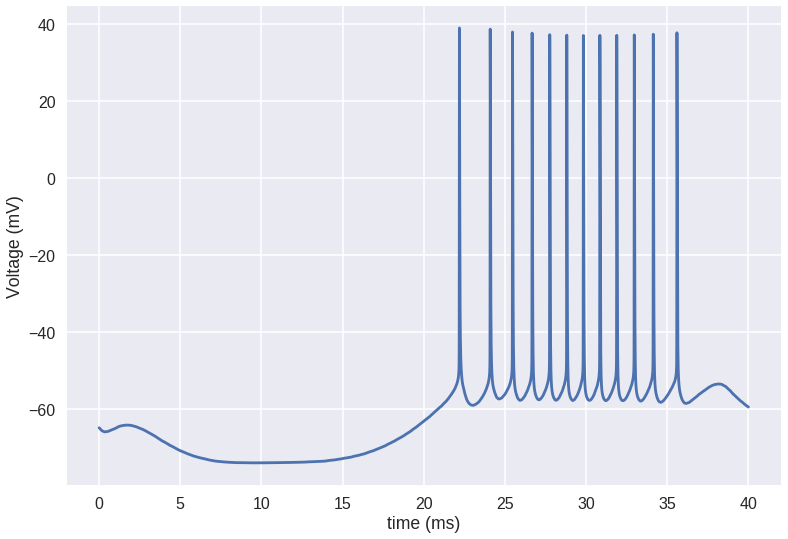

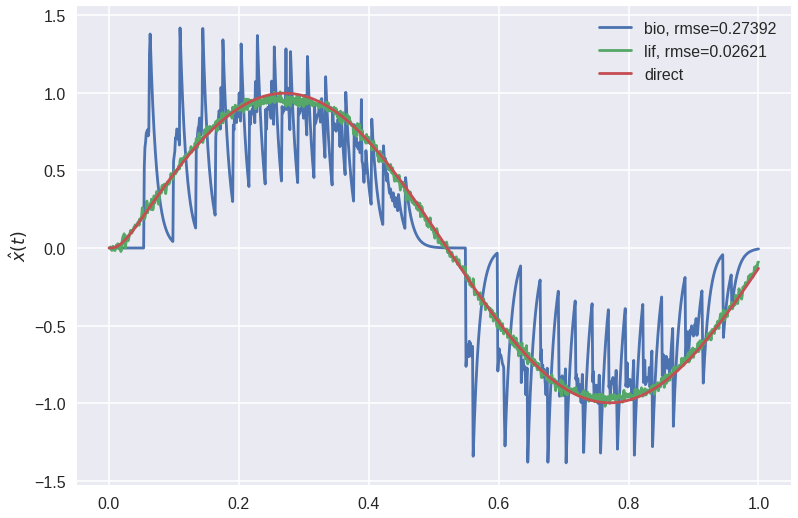

In [17]:
encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

gains=np.ones(gains.shape) #ignore gains
w_bias_from=None
# weights_bias=np.zeros((weights_bias.shape)) #ignore biases

#save decoders for [BIO]-[probe] for later
decoders_bio_1=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
#     n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,syn_locations,weights_bias,
    pre_seed,bio_seed,'prime_sinusoids')

As shown in the spike plot, there isn't yet much heterogeneity in the bioneuron responses.

## Gains, no biases
Now let's have gains multiply encoders, but keep biases set to zero.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:58.                                                 


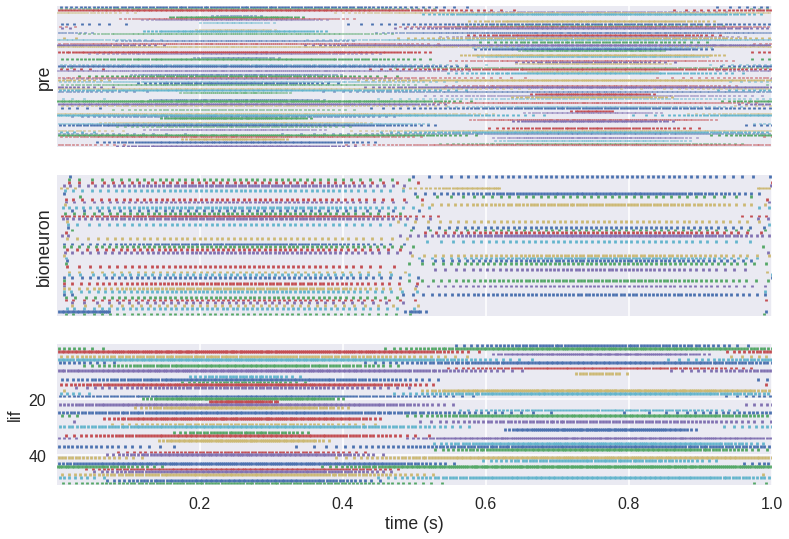

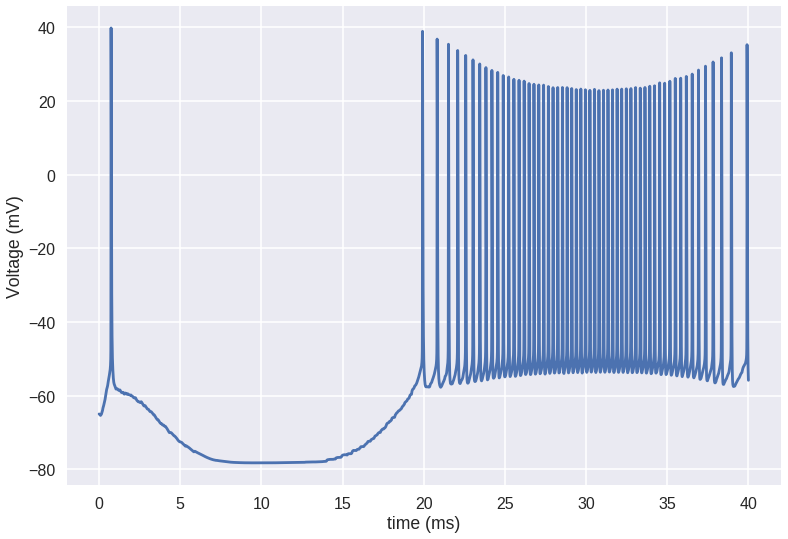

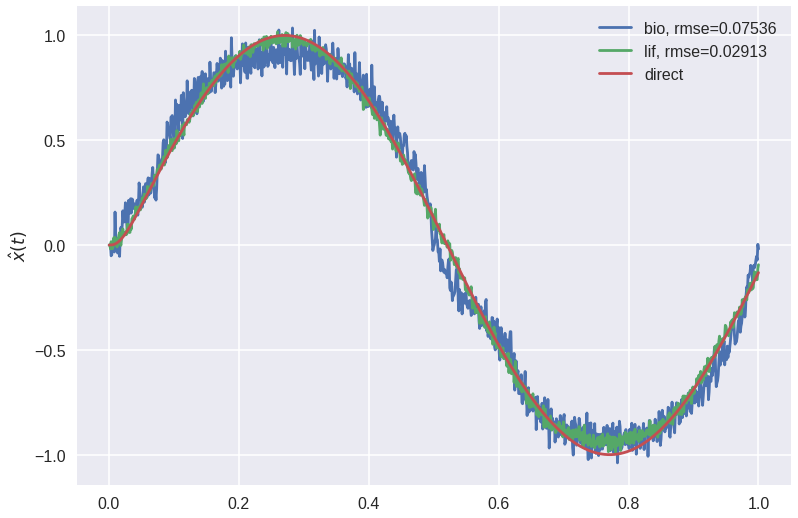

In [15]:
encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

w_bias_from=None

decoders_bio_2=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
    pre_seed,bio_seed,'prime_sinusoids')

That's a much more diverse response, and a good decoding.

## Gains and Biases
Now let's add in the biases by emulating them using Andreas' method.

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:01.                                                 


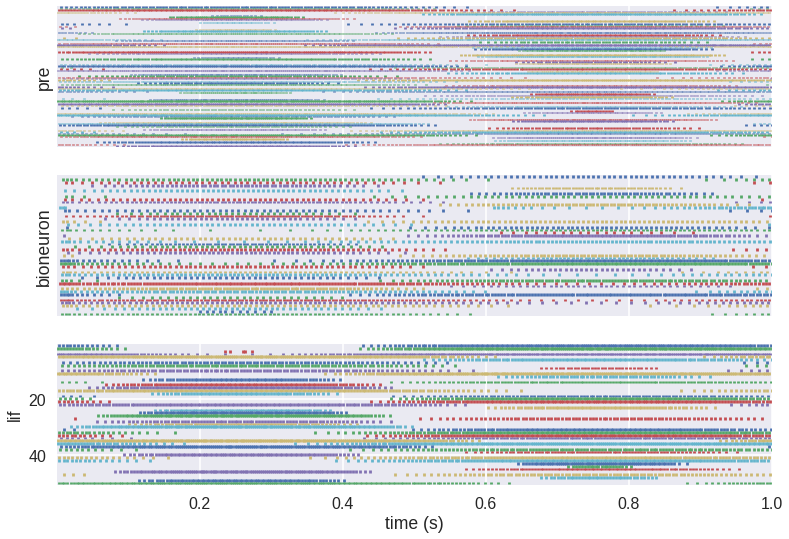

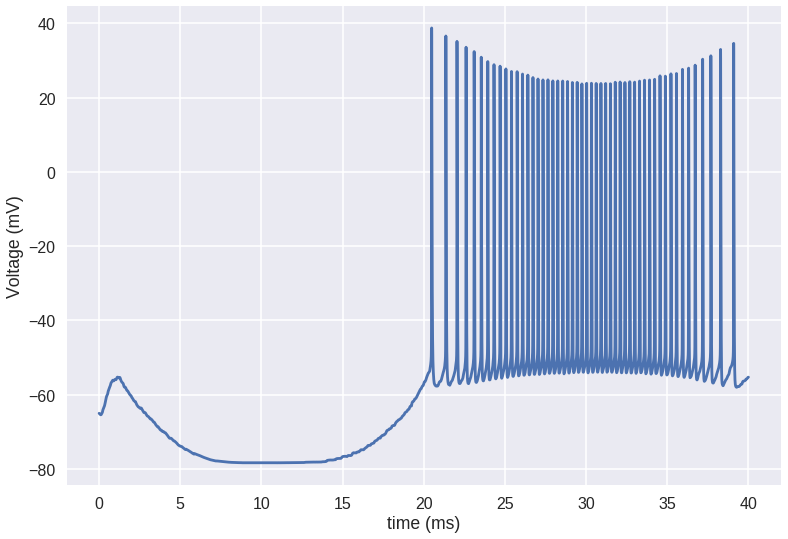

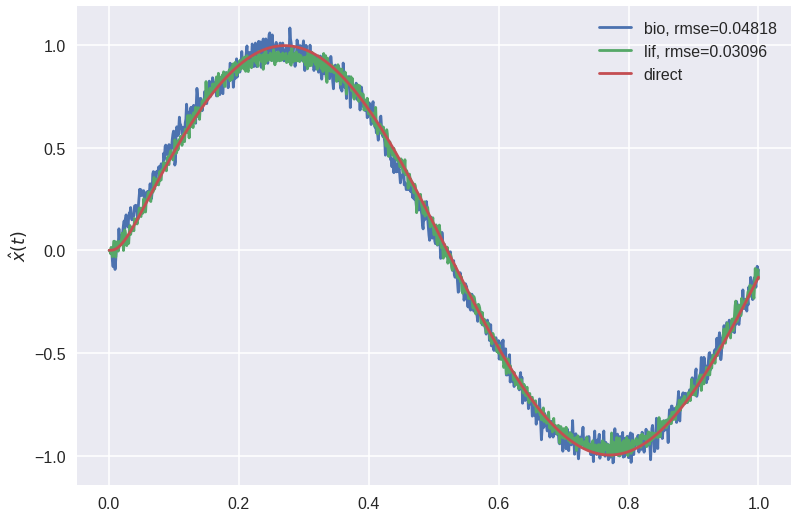

In [18]:
encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

w_bias_from='pre'

decoders_bio_3=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
    pre_seed,bio_seed,'prime_sinusoids')

Looks like adding bias increased the diversity of the bioneuron responses, which further increased the accuracy of the decoding.

## Random decoders

Now let's try and disrupt the decoding by repeating the simulation with a new seed for the pre_LIF population, and hence calculating new [pre]-[lif] weights and weights_bias, but using the same encoders and gains, but using RANDOM decoders. The scale of these decoders will be set by those calculated with the least squares solver in the previous experiment.

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:59.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:67: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


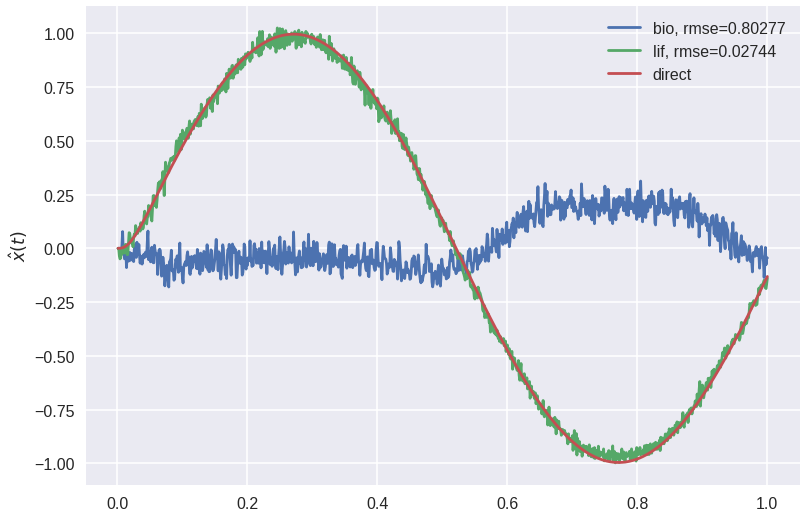

In [23]:
pre_seed=1

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

random_decoders=np.random.RandomState(seed=123).uniform(
    np.min(decoders_bio_3),np.max(decoders_bio_3),size=decoders_bio_3.shape)

w_bias_from='pre'

junk=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
    pre_seed,bio_seed,'prime_sinusoids',decoders_bio=random_decoders,plots={'decode'})

Random decoders are pretty bad, but since the bioneuron activities are still correlated with the sinusoidal signal, the decoded output still has a sinusoidal shape.

## Previously computed decoders
Now let's try using the [bio]-[probe] decoders calculated in the "Gains and Biases" experiment

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:30.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:67: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


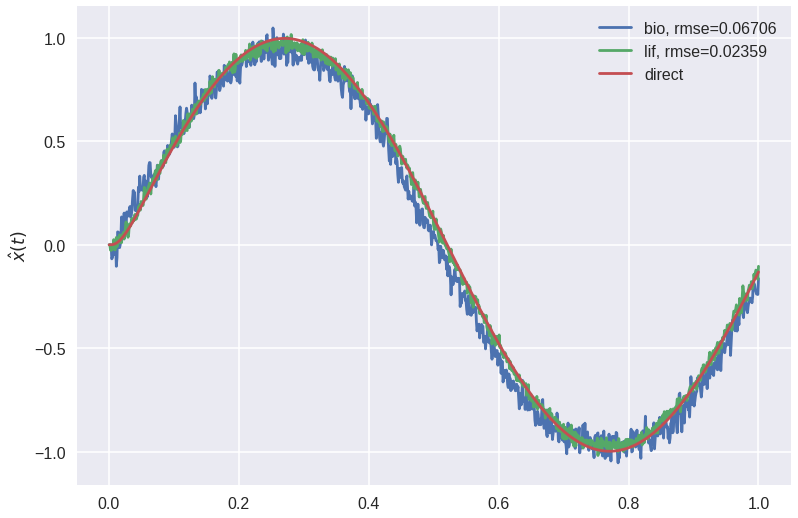

In [24]:
encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

w_bias_from='pre'

junk=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
    pre_seed,bio_seed,'prime_sinusoids',decoders_bio=decoders_bio_3,plots={'decode'})

Very accurate decoding! This is promising evidence for the idea that the bioneuron responses might be identical for similar state-space inputs, even if the presynaptic spike trains are different.

## Multiple dimensions

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:00.                                                 


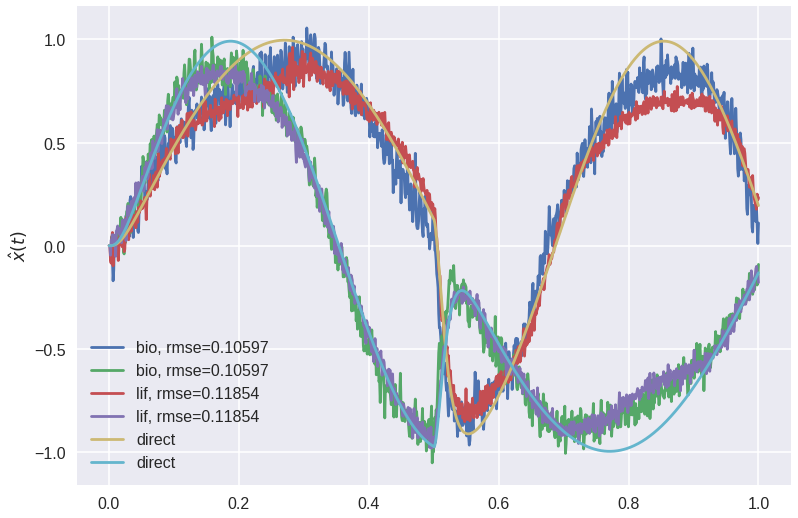

In [25]:
pre_seed=3
bio_seed=6
dim=2
t_final=1.0

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')
junk=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre',
    pre_seed,bio_seed,'prime_sinusoids',plots={'decode'})

Now try using the step_input function for the input stimulus

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:10:12.                                                 


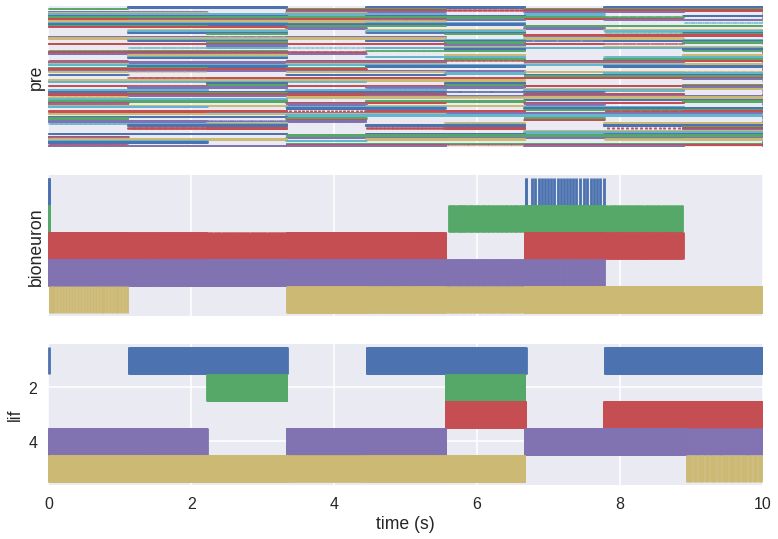

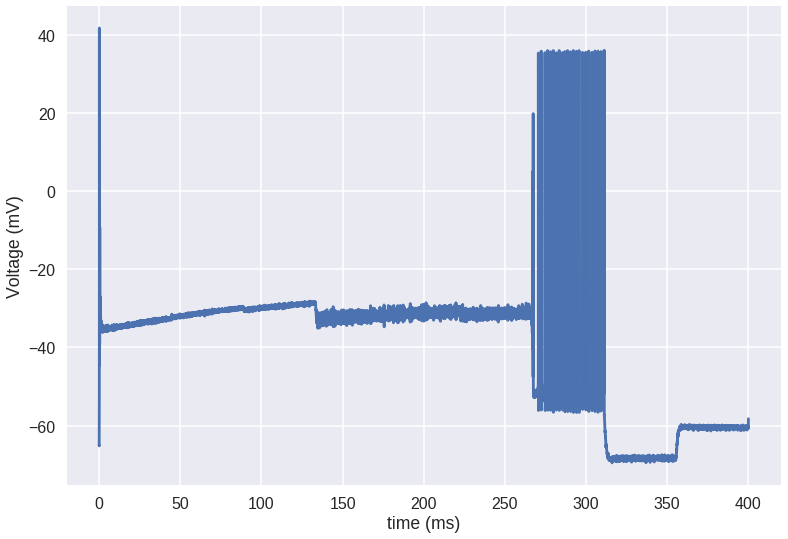

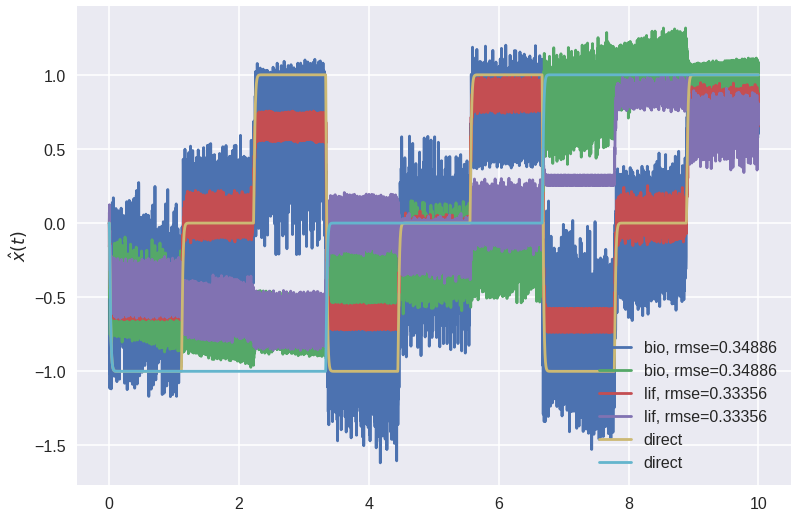

In [28]:
n_neurons=5
dim=2
t_final=10.0
n_eval_points=3

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'step_input',n_eval_points)
junk=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre',
    pre_seed,bio_seed,'step_input',n_eval_points)
# junk=simulate(
#     n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,syn_locations,weights_bias,pre_seed,bio_seed,'step_input',n_eval_points)

## Multiple inputs

In [20]:
def sim_two_inputs(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,w_bias_from,
             pre1_seed,pre2_seed,bio_seed, n_eval_points=10,decoders_bio=None,plots={'decode'}):
    '''
    Simulate a feedforward network [stim]-([LIF1],[LIF2])-[BIO], and compare to [stim]-([LIF1],[LIF2])-[LIF].
    
    encoders: encoders for bioneurons calculated for a hypothetical LIF population in gen_enc_gain_bias()
    bio_seed: ensemble seed for bioensemble
    pre_seed: ensemble seed for lif emsemble
    decoders_bio: use the output decoders for [BIO]-[probe] from a previous simulation rather than
                    calculating them again using nengo.solver.LstsqL2()
    '''
    with nengo.Network() as model:
        stim1 = nengo.Node(lambda t: 0.5*prime_sinusoids(t,dim,t_final))
        stim2 = nengo.Node(lambda t: 0.5*step_input(t,dim,t_final,dt,n_eval_points))
        pre1=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre1',seed=pre1_seed)
        pre2=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre2',seed=pre2_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,w_bias_from))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim1,pre1,synapse=None)
        nengo.Connection(stim2,pre2,synapse=None)
        nengo.Connection(pre1,bio,synapse=tau)
        nengo.Connection(pre2,bio,synapse=tau)
        nengo.Connection(pre1,lif,synapse=tau)
        nengo.Connection(pre2,lif,synapse=tau)
        nengo.Connection(stim1,direct,synapse=tau)
        nengo.Connection(stim2,direct,synapse=tau)

        probe_stim1=nengo.Probe(stim1,synapse=None)
        probe_stim2=nengo.Probe(stim2,synapse=None)
        probe_pre1=nengo.Probe(pre1,synapse=tau)
        probe_pre2=nengo.Probe(pre2,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre1_spikes=nengo.Probe(pre1.neurons,'spikes')
        probe_pre2_spikes=nengo.Probe(pre2.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)
        
    '''make sick plotz'''
    sns.set(context='poster')

    if 'spikes' in plots:
        '''spike raster for BIO and comparison LIF ensembles'''
        figure, (ax2,ax3) = plt.subplots(2,1,sharex=True)
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax3,use_eventplot=True)
        ax3.set(xlabel='time (s)',ylabel='lif') #,yticks=([])

    if 'decode' in plots:
        '''decoded output of bioensemble'''
        figure3,ax4=plt.subplots(1,1,sharex=True)
        lpf = nengo.Lowpass(tau)
        solver = nengo.solvers.LstsqL2(reg=0.01)
        if decoders_bio==None:
            decoders_bio, info = solver(
                                    lpf.filt(sim.data[probe_bio_spikes], dt=dt),
                                    lpf.filt(sim.data[probe_pre1], dt=dt) + lpf.filt(sim.data[probe_pre2], dt=dt))
        A_bio=lpf.filt(sim.data[probe_bio_spikes], dt=dt)
        xhat_bio=np.dot(A_bio,decoders_bio)
        rmse_bio=np.sqrt(np.average((sim.data[probe_direct]-xhat_bio)**2))
        rmse_lif=np.sqrt(np.average((sim.data[probe_direct]-sim.data[probe_lif])**2))
        ax4.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
        ax4.plot(sim.trange(),sim.data[probe_lif],label='lif, rmse=%.5f'%rmse_lif)
        ax4.plot(sim.trange(),sim.data[probe_direct],label='direct')
        ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax4.legend() #prop={'size':8}
    
    delete_bioneurons(bio)
    return decoders_bio

Building finished in 0:00:01.                                                   
Emulating bias from pre1 to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:43.                                                 


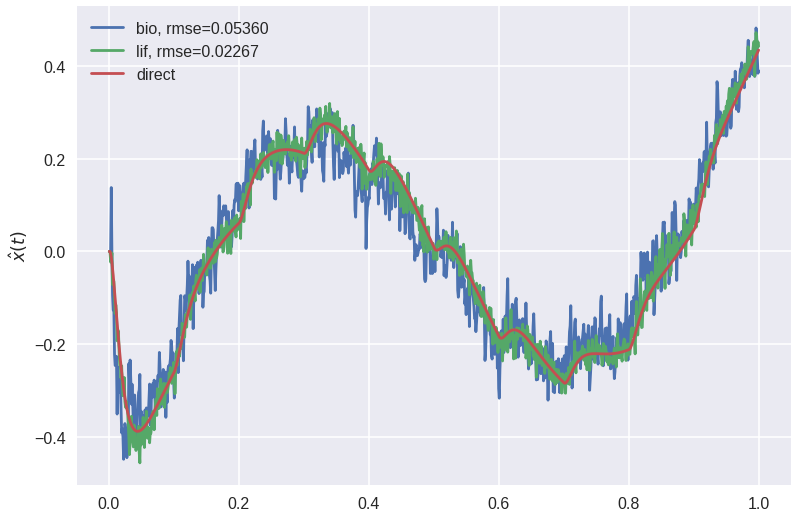

In [34]:
pre_neurons=100
n_neurons=50
tau=0.01
dim=1
n_syn=1
dt=0.001
t_final=1.0
pre1_seed=3
pre2_seed=9
bio_seed=6

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

decoders_bio_two_inputs=sim_two_inputs(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre1',
    pre1_seed,pre2_seed,bio_seed,n_eval_points=10, decoders_bio=None,plots={'decode'})

### Multiple inputs, multiple dimensions

Building finished in 0:00:01.                                                   
Emulating bias from pre1 to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:22.                                                 


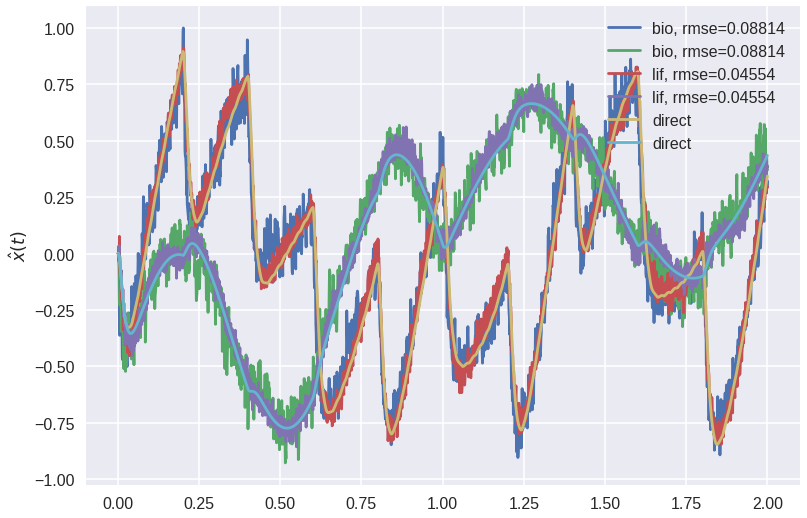

In [35]:
dim=2
t_final=2.0

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

decoders_bio_two_inputs=sim_two_inputs(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre1',
    pre1_seed,pre2_seed,bio_seed,n_eval_points=10,decoders_bio=None,plots={'decode'})

What a wonky signal...

### Multiple inputs, multiple dimensions, new pre LIF seeds but old decoders

Building finished in 0:00:01.                                                   
Emulating bias from pre1 to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:02:40.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:61: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


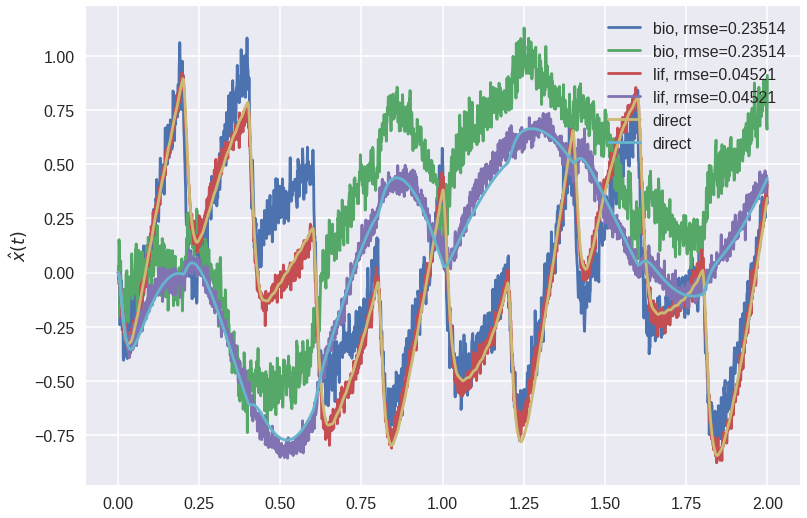

In [36]:
pre1_seed=11
pre2_seed=22

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre1_seed,bio_seed,'prime_sinusoids')

junk=sim_two_inputs(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre1',
    pre1_seed,pre2_seed,bio_seed,n_eval_points=10,decoders_bio=decoders_bio_two_inputs,plots={'decode'})

This BIO RMSE seems to have increased with my weight_bias refactoring. In the previous version I hardcoded sim_two_inputs() to only decode off of 'pre1', which this code should be doing explicitly with w_bias_from='pre1', so I'm not sure where this error comes from. The decode does seem to be off by a positive constant, though, so there may be a problem with the bias somewhere.

### Multiple synapses, different synaptic locations on each bioneuron
Begin with 1 dimension and 1 input. Redefine build_connections() to reflect this distribution of synapses.

In [21]:
def get_syn_locations(rng,conn):
    '''same locations per connection and unique locations per bioneuron'''
    rng2=np.random.RandomState(seed=333)
    syn_locations=rng2.uniform(0,1,size=(conn.post.n_neurons,conn.pre.n_neurons,n_syn))
    return syn_locations

In [22]:
def get_weights_bias(conn):
    print 'Emulating bias from %s to %s'%(conn.pre.label,conn.post.label)
    e, g, weights_bias = gen_enc_gain_bias(
            conn.pre.n_neurons,conn.post.n_neurons,conn.synapse,conn.post.dimensions,
            n_syn,0.001,1.0,conn.pre.seed,conn.post.seed,'prime_sinusoids')
    return weights_bias

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:02:01.                                                 


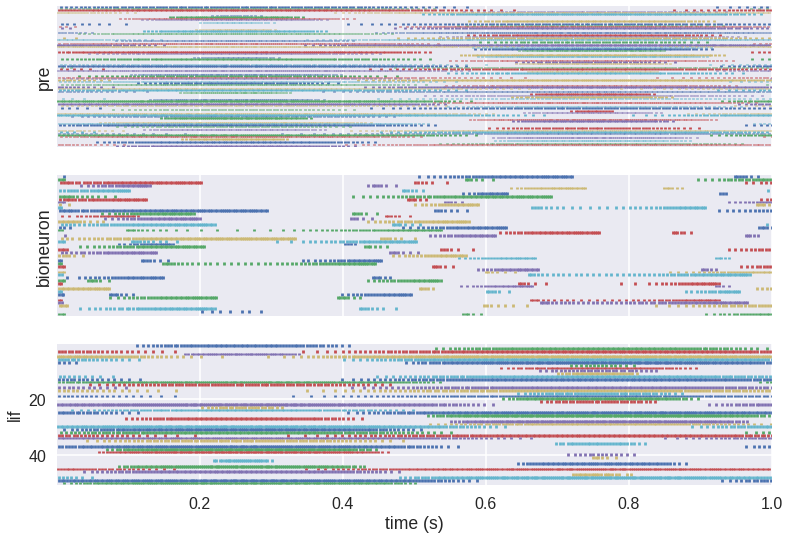

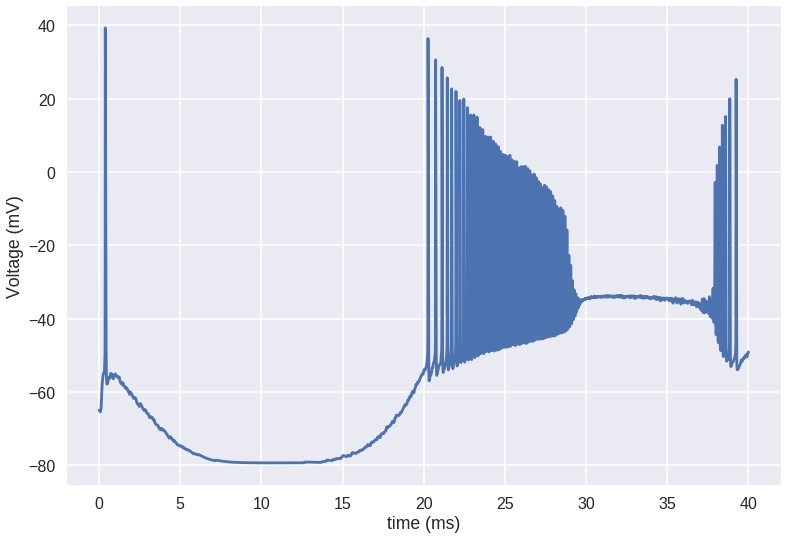

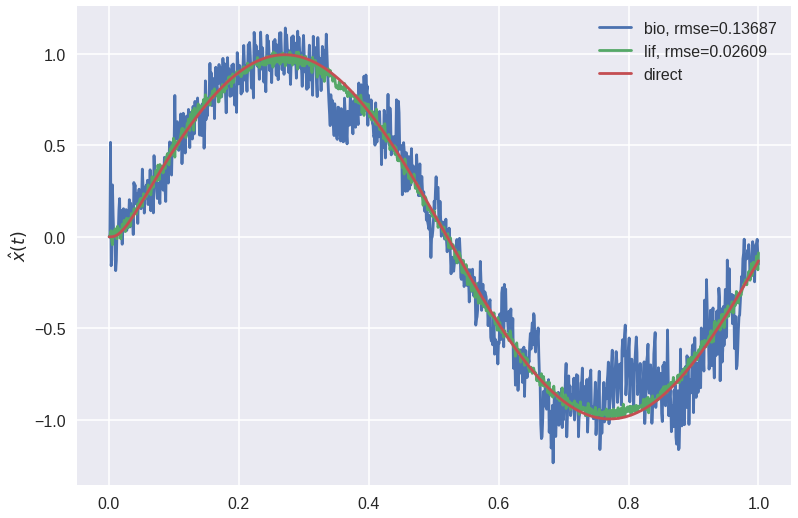

In [23]:
pre_neurons=100
n_neurons=50
tau=0.01
dim=1
n_syn=10
dt=0.001
t_final=1.0
pre_seed=3
bio_seed=6

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

decoders_bio=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre',
    pre_seed,bio_seed,'prime_sinusoids')

The voltage plot shows that some neurons will fire rapidly and become exhausted, with their voltage settling above -40mV despite continued input. This is a sign that we're driving the bioneurons too hard, which is expected given we're giving it the same weighted input on each synapse, but there are 10 synapses. To compensate for this, divide gains and weights_bias by $n_{syn}$. 

In [24]:
def get_weights_bias(conn):
    print 'Emulating bias from %s to %s'%(conn.pre.label,conn.post.label)
    e, g, weights_bias = gen_enc_gain_bias(
            conn.pre.n_neurons,conn.post.n_neurons,conn.synapse,conn.post.dimensions,
            n_syn,0.001,1.0,conn.pre.seed,conn.post.seed,'prime_sinusoids')
    return weights_bias / n_syn # << ====== add this division

Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:02:01.                                                 


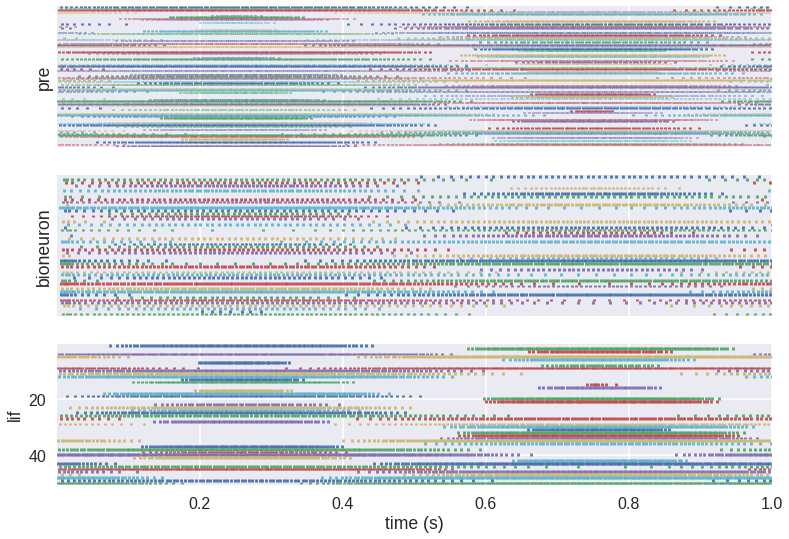

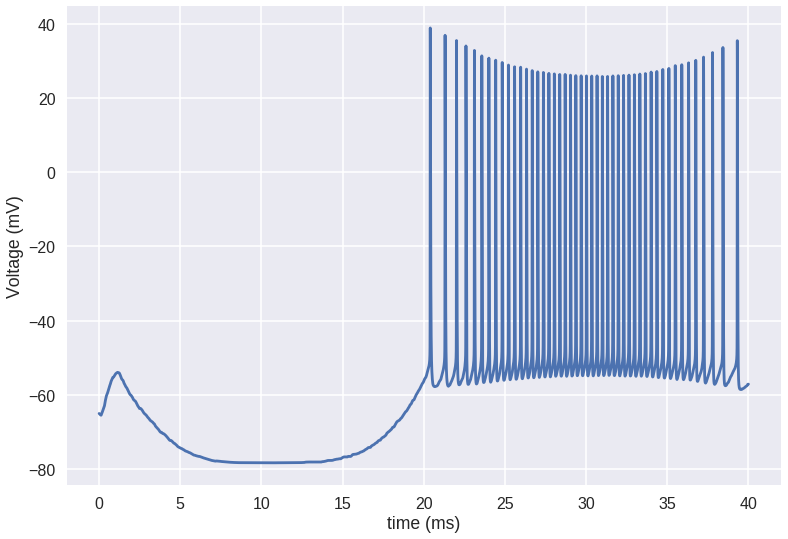

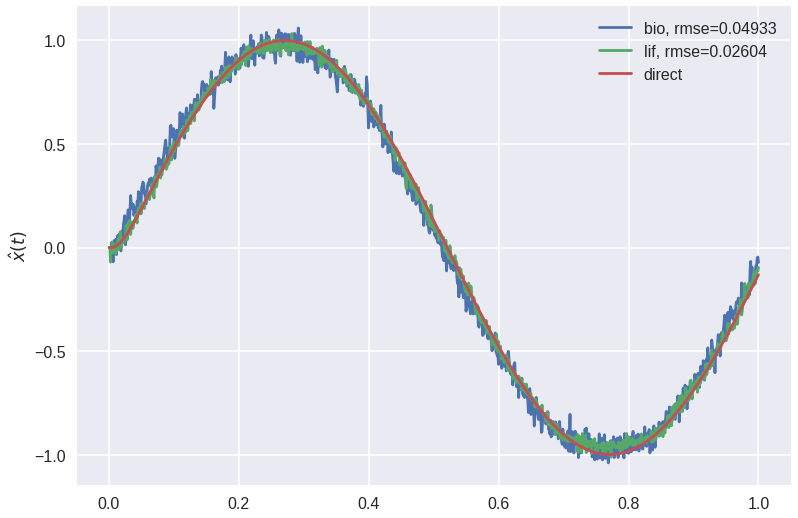

In [25]:
n_syn=10
pre_seed=3
bio_seed=6

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

gains = gains / n_syn

decoders_bio=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre',
    pre_seed,bio_seed,'prime_sinusoids')

Very similar RMSE to the experiment with gains, biases, and 1 synapse.

Now try multiple dimensions and multiple inputs. The same synaptic locations will be used for each input.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Emulating bias from pre1 to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:04.                                                   
Simulating finished in 0:07:18.                                                 


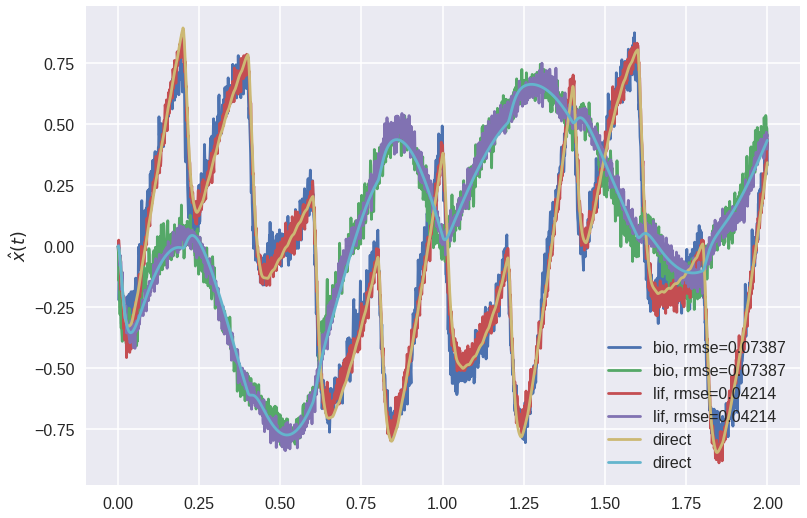

In [26]:
pre1_seed=3
pre2_seed=9
bio_seed=6
dim=2
n_syn=10
t_final=2.0

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre1_seed,bio_seed,'prime_sinusoids')

gains = gains / n_syn

decoders_bio=sim_two_inputs(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre1',
    pre1_seed,pre2_seed,bio_seed,n_eval_points=10,decoders_bio=None,plots={'decode'})

Finally, use unique synaptic locations for each input and for each bioneuron.

In [27]:
def get_syn_locations(rng,conn):
    '''unique locations per connection and per bioneuron'''
    #uses the rng on conn
    syn_locations=rng.uniform(0,1,size=(conn.post.n_neurons,conn.pre.n_neurons,n_syn))
    return syn_locations

Building finished in 0:00:01.                                                   
Emulating bias from pre1 to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:06.                                                   
Simulating finished in 0:07:33.                                                 


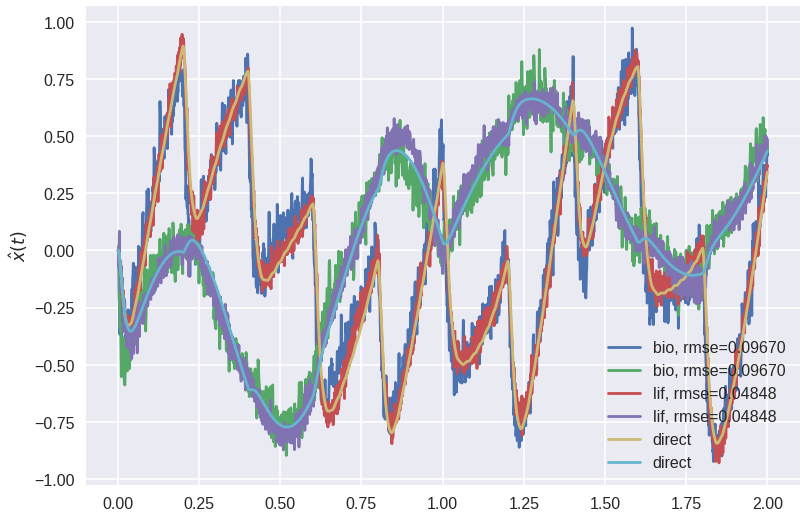

In [28]:
pre1_seed=3
pre2_seed=9
bio_seed=6
dim=2
n_syn=10
t_final=2.0

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre1_seed,bio_seed,'prime_sinusoids')

gains = gains / n_syn

decoders_bio=sim_two_inputs(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,'pre1',
    pre1_seed,pre2_seed,bio_seed,n_eval_points=10,decoders_bio=None,plots={'decode'})

# Tuning Curve Unit Test

In [ ]:
def tuning_curve_delta_rates(n_neurons,
                                tau,
                                dim,
                                n_syn,
                                dt,
                                encoders,
                                gains,
                                syn_locations,
                                weights_bias,
                                pre_seed,
                                bio_seed,
                                input_type,
                                n_eval_points=10,
                                decoders_bio=None,
                                plots={'tuning_bio'}):
    
    '''
    Simulates a [stim]-[LIF]-[BIO] network with an input U(t) that covers the state space,
    gathers the bioneurons' activities, and associates them with U(t) to produce tuning curves.
    
    input_type: a 'prime_sinusoid or 'step_input' signal for for each dimension
    decoders_bio: load in previously computed decoders out of [BIO] that will be used to find x_hat
    plots: dictionary of strings relating which plots to draw
    '''

    with nengo.Network() as model:
        if input_type == 'prime_sinusoids':
            stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        elif input_type == 'step_input':
            stim = nengo.Node(lambda t: step_input(t,dim,t_final,dt,n_eval_points))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,syn_locations,weights_bias))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)

    columns=('t_idx','x_dot_e','x_dot_e_bin','t','neuron','rate_bio','rate_lif')
    for d in range(dim):
        columns=columns+('x_%s'%d,)
    df=pd.DataFrame(columns=columns,index=np.arange(0,n_neurons*(sim.trange().shape[0]-1)))
    
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return array[idx]
        
    lpf=nengo.Lowpass(tau)
    delta_rates=np.zeros((n_neurons))
    print 'Constructing Pandas Dataframe...'
    j=0
    for bionrn in range(n_neurons):
        rates_bio=lpf.filt(sim.data[probe_bio_spikes][:,bionrn],dt=dt)
        rates_lif=lpf.filt(sim.data[probe_lif_spikes][:,bionrn],dt=dt)
        x_dot_e=np.dot(sim.data[probe_pre],encoders[bionrn])
        delta_rates[bionrn]=np.max(rates_bio)-np.min(rates_bio)
        x_dot_e_vals=np.linspace(np.min(x_dot_e),np.max(x_dot_e),num=n_eval_points)

        for t in np.arange(1,sim.trange().shape[0]):
            x_dot_e_bin=np.round(find_nearest(x_dot_e_vals,x_dot_e[t]),decimals=1)
            info=[t.astype(int),x_dot_e[t],x_dot_e_bin,t*dt,str(bionrn),rates_bio[t],rates_lif[t]]
            for d in range(dim):
                info.append(sim.data[probe_pre][t,d])
            df.loc[j]=info
            j+=1

    if 'stim' in plots:
        sns.set(context='poster')
        figure3,ax3=plt.subplots(1,1)
        ax3.plot(sim.trange(),sim.data[probe_stim])
        ax3.set(ylabel='stim')
    if 'spikes' in plots:
        figure2,ax2=plt.subplots(1,1)
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
    if '2d_heatmap' in plots:
        assert dim==2
        fig_heatmap,ax_heatmap=plt.subplots(1,1)
#         sns.jointplot('x_0','x_1',data=df,kind='kde',ax=ax_heatmap)
        heatmap=df.query('neuron=="1"').pivot('x_0','x_1','rate_bio')
        sns.heatmap(heatmap,ax=ax_heatmap)
        ax_heatmap.set(xlabel='$x_0$',ylabel='$x_1$',title='rates_bio')
    if 'tuning_bio' in plots:
        figure1,ax1=plt.subplots(1,1)
        sns.stripplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',jitter=True,data=df)
        ax1.set(xlabel='$x . e_j$',ylabel='BIO firing rate (hz)')
    if 'tuning_lif' in plots:
        figure4,ax4=plt.subplots(1,1)
        sns.stripplot(x='x_dot_e_bin',y='rate_lif',hue='neuron',jitter=True,data=df)
        ax4.set(xlabel='$x . e_j$',ylabel='LIF firing rate (hz)')
                
    return np.array(delta_rates),df

While there are bioneurons whose min and max firing rate differ by less than the delta_rates_threshold, keep choosing new encoders and weights_bias for those.

Measure min and max rate in response to an input signal that is either sinusoidal (each dimension has a sinusoid with prime frequencies), or step inputs (ranging from x_min to x_max in each dimension). 

In [ ]:
pre_neurons=100
n_neurons=5
tau=0.01
dim=2
n_syn=1
dt=0.001
t_final=10.0
n_eval_points=20
pre_seed=3
bio_seed=6
delta_rates_threshold=5
rng=np.random.RandomState(seed=333)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])


#first guess for bioneuron parameters
encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

idx_unresponsive=np.arange(0,n_neurons) #array of bio_idx that don't cross rate threshold
while idx_unresponsive.shape[0] != 0:
    delta_rates,df=tuning_curve_delta_rates(
            n_neurons,tau,dim,n_syn,dt,encoders,gains,syn_locations,weights_bias,
            pre_seed,bio_seed,'prime_sinusoids',n_eval_points,decoders_bio=None,plots={'tuning_bio','tuning_lif'})
    idx_unresponsive=np.where(delta_rates<delta_rates_threshold)[0]
    print 'delta rates:', delta_rates
    for n in idx_unresponsive:
        encoders[n], gains[n], weights_bias[n] = gen_enc_gain_bias(
                    pre_neurons,1,tau,dim,n_syn,dt,t_final,rng.randint(336699),bio_seed,'prime_sinusoids')

decoders_bio_6=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,syn_locations,weights_bias,
    pre_seed,bio_seed,'prime_sinusoids',plots={'decode'})

It's hard to tell with the overlap in the tuning curve plots, but the bioneuron activities seem to vary smoothly with the encoded input $x . e_j$. This indicates that similar points in the state space are being mapped onto similar bioneuron responses.

### I can't figure out how to plot the tuning curves using sns.tsplot(), or even a time series using this function

In [ ]:
n_neurons=5
dim=2
dt=0.001
t_final=1.0
n_eval_points=10
pre_seed=3
bio_seed=6
rng=np.random.RandomState(seed=333)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])

encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

delta_rates,df=tuning_curve_delta_rates(n_neurons,tau,dim,n_syn,dt,encoders,gains,syn_locations,weights_bias,
                                        pre_seed,bio_seed,'prime_sinusoids',n_eval_points,
                                        decoders_bio=None,plots={'tuning_bio','tuning_lif'})

In [ ]:
print df.loc[0]

print (type(df.loc[0]['x_dot_e']),
type(df.loc[0]['x_dot_e_bin']),
type(df.loc[0]['t']),
type(df.loc[0]['neuron']),
type(df.loc[0]['rate_bio']),
type(df.loc[0]['rate_lif']),
type(df.loc[0]['x_0']),
type(df.loc[0]['x_1']))

figure1,ax1=plt.subplots(1,1)
ax1.set(xlabel='$x . e_j$',ylabel='BIO firing rate (hz)')

'''Throws unsupported operand type(s) for +: 'NoneType' and 'NoneType' '''
# sns.tsplot(time="t",value="rate_bio",condition='neuron',data=df,ax=ax1) #how tsplot should be used
# sns.tsplot(time="x_dot_e_bin",value="rate_bio",unit='t_idx',condition='neuron',data=df,ax=ax1)  #how I want to plot tuning curves

#Matplotlib workaround
# for bionrn in range(n_neurons):
#     df_i=df.query('neuron=="%s"'%bionrn)
#     x=df_i['x_dot_e_bin']
#     y=df_i['rate_bio']
#     ax1.plot(x,y,label=str(bionrn),marker='o',linestyle='')

heatmap=df.query('neuron=="1"')
print heatmap
heatmap=heatmap.pivot('x_0','x_1','rate_bio')
print heatmap
sns.heatmap(heatmap)

In [ ]:
gammas = sns.load_dataset("gammas")

gammas.loc[0]

print (type(gammas.loc[0]['timepoint']),
type(gammas.loc[0]['ROI']),
type(gammas.loc[0]['subject']),
type(gammas.loc[0]['BOLD signal']))

figure1,ax1=plt.subplots(1,1)
# sns.boxplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',data=df)
sns.tsplot(time="timepoint",value="BOLD signal",unit='subject',condition='ROI',data=gammas,ax=ax1)
ax1.set(xlabel='$t$',ylabel='BOLD')

flights = sns.load_dataset("flights")

print flights

flights = flights.pivot("month", "year", "passengers")

flights